In [31]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.random import randn
from numpy.random import randint
from tqdm import tqdm as tqdm
from src.assoc_utils_np import train_gcpc
from src.assoc_utils_np_2D import gen_gbook_2d, path_integration_Wgg_2d, module_wise_NN_2d
from src.seq_utils import *
plt.style.use('./src/presentation.mplstyle')
plt.rcParams['figure.autolayout'] = False

from sklearn.linear_model import Perceptron
from sklearn.neural_network import MLPClassifier

Set up scaffold network

In [167]:
nruns=1
Np = 400
lambdas = [3,4,5,7] #[3,4,5] 
Ng = np.sum(np.square(lambdas))
Npos = np.prod(lambdas)
gbook = gen_gbook_2d(lambdas, Ng, Npos)

Wpg = randn(nruns, Np, Ng) 
c = 0.10     # connection probability
prune = int((1-c)*Np*Ng)
mask = np.ones((Np, Ng))
mask[randint(low=0, high=Np, size=prune), randint(low=0, high=Ng, size=prune)] = 0
Wpg = np.multiply(mask, Wpg)


In [168]:
thresh = 2.0
pbook = nonlin(np.einsum('ijk,klm->ijlm', Wpg, gbook), thresh=thresh)  # (nruns, Np, Npos, Npos) 
gbook_flattened = gbook.reshape(Ng, Npos*Npos)  #order='F'
pbook_flattened = pbook.reshape(nruns, Np, Npos*Npos)
Wgp = train_gcpc(pbook_flattened, gbook_flattened,Npatts=Npos**2)

# Setting up splitter cell env

In [6]:
bottom_stem = 5
height = 25
action_list = []
start = np.array([0,0])
actions_dict = {        'u':np.array([0,1]),
                        'r':np.array([1,0]),
                        'dr':np.array([1,-1]),
                        'd':np.array([0,-1]),
                        'l':np.array([-1,0]),
                        'ul':np.array([-1,1])}

In [7]:
right_path_actions = []

#right_path.append(start)
for i in range(height):
    right_path_actions.append(actions_dict['dr'])

for i in range(bottom_stem):
    right_path_actions.append(actions_dict['r'])

for i in range(height):
    if i%2==0:
        right_path_actions.append(actions_dict['u'])
    else:
        right_path_actions.append(actions_dict['ul'])
    
for i in range(height//2 + bottom_stem):
    right_path_actions.append(actions_dict['r'])


In [8]:
left_path_actions = []

#left_path.append(start)
for i in range(height):
    left_path_actions.append(actions_dict['d'])

for i in range(bottom_stem):
    left_path_actions.append(actions_dict['l'])

for i in range(height):
    if i%2==0:
        left_path_actions.append(actions_dict['u'])
    else:
        left_path_actions.append(actions_dict['ul'])
    
for i in range(height//2 + bottom_stem):
    left_path_actions.append(actions_dict['l'])

In [9]:
positions_r = []
positions_r.append(start)
i=1
for action in right_path_actions:
    positions_r.append(positions_r[i-1]+action)
    i = i+1

positions_r = np.array(positions_r)

positions_l = []
# positions_l.append(start)
positions_l.append(positions_r[-1])
i=1
for action in left_path_actions:
    positions_l.append(positions_l[i-1]+action)
    i = i+1

positions_l = np.array(positions_l)

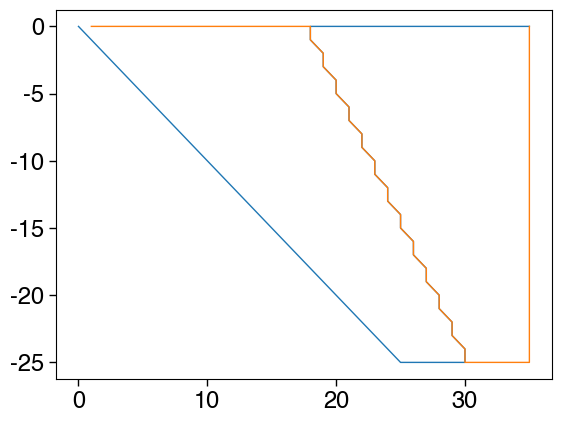

In [10]:
plt.plot(positions_r[:,0],positions_r[:,1])
plt.plot(positions_l[:,0],positions_l[:,1])
plt.show()

In [11]:
# Full "maze"
path_locations_1 = positions_r + 100
path_locations_2 = positions_l + 100

In [12]:
# "Maze" after remapping
path_locations_1 = positions_r + 30
path_locations_2 = positions_l + 60

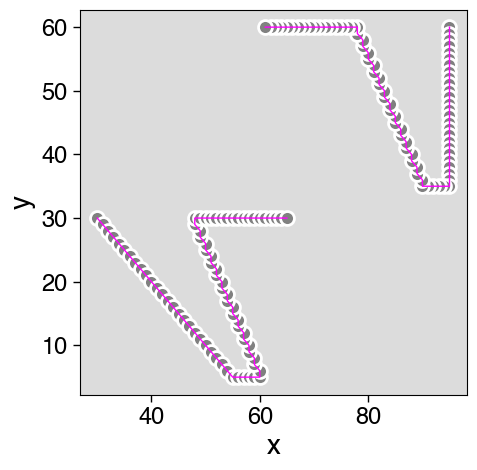

In [15]:
plt.figure(figsize=(5,5))
ax = plt.axes()
ax.set_facecolor("gainsboro")
plt.scatter(*zip(*path_locations_1),color="gray", s=100, edgecolors="white", linewidths=2)
plt.plot(*zip(*path_locations_1),'-', color="magenta")
plt.scatter(*zip(*path_locations_2),color="gray", s=100, edgecolors="white", linewidths=2)
plt.plot(*zip(*path_locations_2),'-', color="magenta")
plt.ylabel("y", fontsize="20")
plt.xlabel("x", fontsize="20")
#plt.grid()
plt.show()

# Learning paths in env as sequence predictions 

In [16]:
#path_locations = path_locations_1    # route 1
path_locations = path_locations_2   # route 2

In [20]:
Npatts = len(path_locations)
Ns = Npatts 
x,y = Npos ,Npos # Npos, Npos
sbook = sens_nonlin(randn(Ns, x, y))
sbook_flattened = sbook.reshape(Ns, x*y)

In [23]:
abook = actions(path_locations)
path_pbook, path_sbook = path_codes(path_locations, pbook, sbook)  
Wsp = sensorymap(path_sbook, path_pbook)

In [29]:
# learn action mapping from place to actions through perceptron algorithm
n_run = 0
X = path_pbook[n_run].T
y = abook.T
model = MLPClassifier(hidden_layer_sizes=(30,), activation="relu", random_state=1, max_iter=12000).fit(X, y)
model.fit(X, y)
print(model.score(X,y))
wts = model.coefs_
intercepts = model.intercepts_

1.0


In [32]:
# Predicting G, P and S states through learned sequence
path_locations_flattened = [x*Npos+y for x, y in path_locations]
decoded_path_locations = []

nsteps = len(path_locations_flattened)
n_run=0
k = 0
g = gbook_flattened[:,int(path_locations_flattened[0])]
err_g = np.zeros(nsteps)
err_p = np.zeros(nsteps)
err_s = np.zeros(nsteps)
for i in tqdm(path_locations_flattened): 
    # print(k)
    k+=1
    decoded_path_locations.append(gcode_to_coord(g[None,:,None], gbook_flattened,Npos))
    
    err_g[k-1] = np.sum(np.abs(g.flatten()-gbook_flattened[:,i]))
    
    p = nonlin(Wpg@g, thresh=thresh)
        
    err_p[k-1] = np.sum(np.abs(p[n_run].flatten()-pbook_flattened[n_run,:,i]))/(2*Np)
    
    s = np.sign(Wsp@p[:,:,None])
    err_s[k-1] = np.linalg.norm(s[n_run].flatten()-sbook_flattened[:,i])/(2*Ns)
        
    
    a = model.predict(p[:1])
    action = int(a[n_run])      # run0

    # 1d actions
    axis, direction = oneDaction_mapping(action)
    if axis == None:
        continue
    # print("Action: ", axis, direction)
    
    if isinstance(axis, list):
        Wgg = path_integration_Wgg_2d(lambdas, Ng, axis=axis[0], direction=direction[0])  
        g = Wgg@g
        Wgg = path_integration_Wgg_2d(lambdas, Ng, axis=axis[1], direction=direction[1])
        g = Wgg@g
    else:
        Wgg = path_integration_Wgg_2d(lambdas, Ng, axis=axis, direction=direction)
        g = Wgg@g
    np.squeeze(g)

print("max g error at any step = "+str(np.amax(err_g)))
print("max p error at any step = "+str(np.amax(err_p)))
print("max s error at any step = "+str(np.amax(err_s)))

100%|██████████████████████████████████████████████████████████████████████████████████| 73/73 [00:02<00:00, 26.30it/s]

max g error at any step = 0.0
max p error at any step = 3.885780586188048e-18
max s error at any step = 0.0


C:\Users\chand\AppData\Local\Temp\ipykernel_25324\2780263015.py:2: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(121)


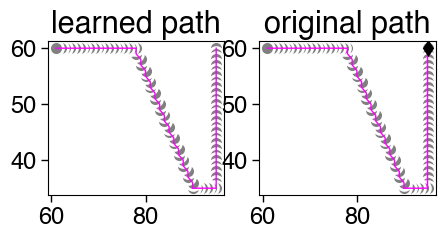

In [44]:
plt.subplots(figsize=(5,2))
plt.subplot(121)
plt.scatter(*zip(*decoded_path_locations), color="gray", s=100, edgecolors="white", linewidths=2)
plt.plot(*zip(*decoded_path_locations), '-', color="magenta")
plt.title('learned path');
# plt.show()
plt.subplot(122)
plt.scatter(*zip(*path_locations), color="gray", s=100, edgecolors="white", linewidths=2)
plt.plot(*zip(*path_locations), '-', color="magenta")
plt.plot(*path_locations[0], 'd-', color="black")
plt.title('original path');
plt.show()


# Transforming data to visualize on hexagonal lattice

In [58]:
import scipy.io 
mat = scipy.io.loadmat('pos420by420.mat')
hexgbook_map = mat["newpos"]

## Map paths and fields to hexagonal grid

In [169]:
hex_path_locations_1 = mapRealtoHex(hexgbook_map, path_locations_1)
hex_path_locations_2 = mapRealtoHex(hexgbook_map, path_locations_2)

In [170]:
idx = 23 # cell indx
grid_fields_1 = []
grid_fields_2 = []

for i in range(len(path_locations_1)):
    grid_fields_1.append(gbook[idx,path_locations_1[i][0], path_locations_1[i][1]])
    
for i in range(len(path_locations_2)):
    grid_fields_2.append(gbook[idx,path_locations_2[i][0], path_locations_2[i][1]])    


(41.0, 129.0, 1.9485571585149866, 54.34309408747352)

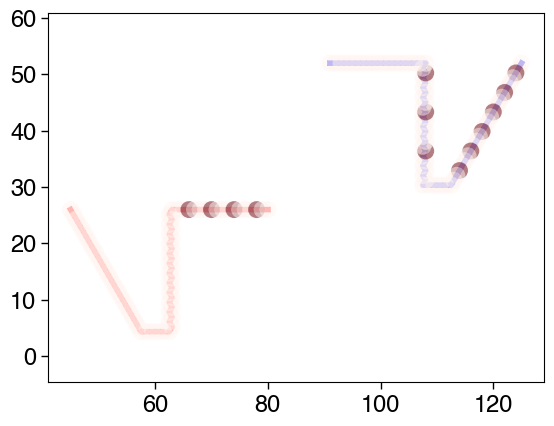

In [171]:
# trajectories
plt.plot(*zip(*hex_path_locations_1),'-', color="red", linewidth=4,zorder=1)
plt.plot(*zip(*hex_path_locations_2),'-', color="blue", linewidth=4,zorder=1)
# grid fields
plt.scatter(*zip(*hex_path_locations_1), c=grid_fields_1, s=150, edgecolors="white", linewidths=0.1, cmap = 'Reds', vmin=0, vmax=1,zorder=2,alpha=0.5)
plt.scatter(*zip(*hex_path_locations_2), c=grid_fields_2, s=150, edgecolors="white", linewidths=0.1, cmap = 'Reds', vmin=0, vmax=1,zorder=2,alpha=0.5)
plt.axis('equal')

# Smooth Grid Tuning Curve

In [231]:
cell_idx = 23
grid_fields = gbook_flattened[cell_idx]

gbook_prenonlin = np.squeeze(Wgp@pbook_flattened)
grid_fields_prenonlin = gbook_prenonlin[cell_idx]

maxfr_gf = np.max(grid_fields)
maxfr_gfpre = np.max(grid_fields_prenonlin)
avg_fields = np.mean((grid_fields_prenonlin/maxfr_gfpre, grid_fields/maxfr_gf), axis=0)
#avg_fields is activity averaged across pre-CAN dynamics and post CAN dynamics in grid cells

In [194]:
# hexed_afs = smooth_tuningcurve(grid_fields, Npos, mult=2, path=True, path_locations=path_locations_1)        
hexed_afs = smooth_tuningcurve(avg_fields, Npos, mult=2, path=True, path_locations=path_locations_1)        
hexed_afs_up_smooth = explicit_interpolation(hexed_afs, sigma=10)

(-10.0, 50.0)

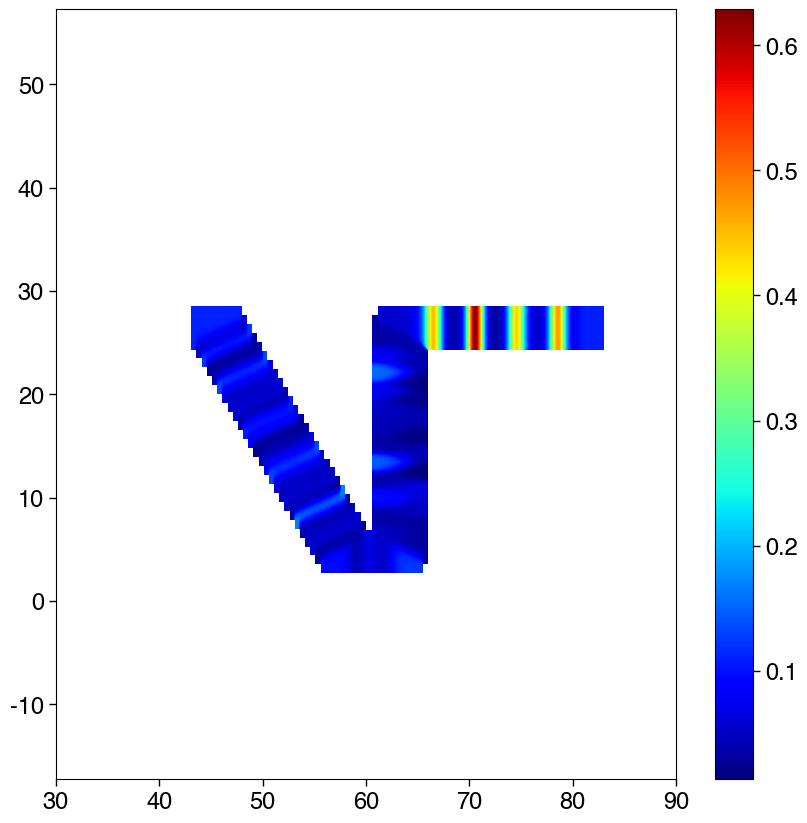

In [195]:
sq32 = np.sqrt(3)/2
fig = plt.figure(figsize=(10,10))
plt.imshow(hexed_afs_up_smooth,cmap='jet',extent=[0,Npos,Npos*sq32,0*sq32],aspect=sq32)
plt.colorbar()
plt.axis("equal")
# plt.xlim(80,140)
# plt.ylim(25,59)


plt.xlim(30,90)
plt.ylim(-10,50)


# Smooth Place Tuning Curve

In [202]:
cell_idx = 219
place_fields = pbook_flattened[0, cell_idx]

# pbook_prenonlin = np.squeeze(Wpg@gbook_flattened)
# place_fields_prenonlin = pbook_prenonlin[cell_idx]

# maxfr_pf = np.max(place_fields)
# maxfr_pfpre = np.max(place_fields_prenonlin)
# avg_fields = np.mean((place_fields_prenonlin/maxfr_pfpre, place_fields/maxfr_pf), axis=0)

In [203]:
hexed_afs = smooth_tuningcurve(place_fields, Npos, mult=2, path=True, path_locations=path_locations_1)        
hexed_afs_up_smooth = explicit_interpolation(hexed_afs, sigma=10)

(-10.0, 50.0)

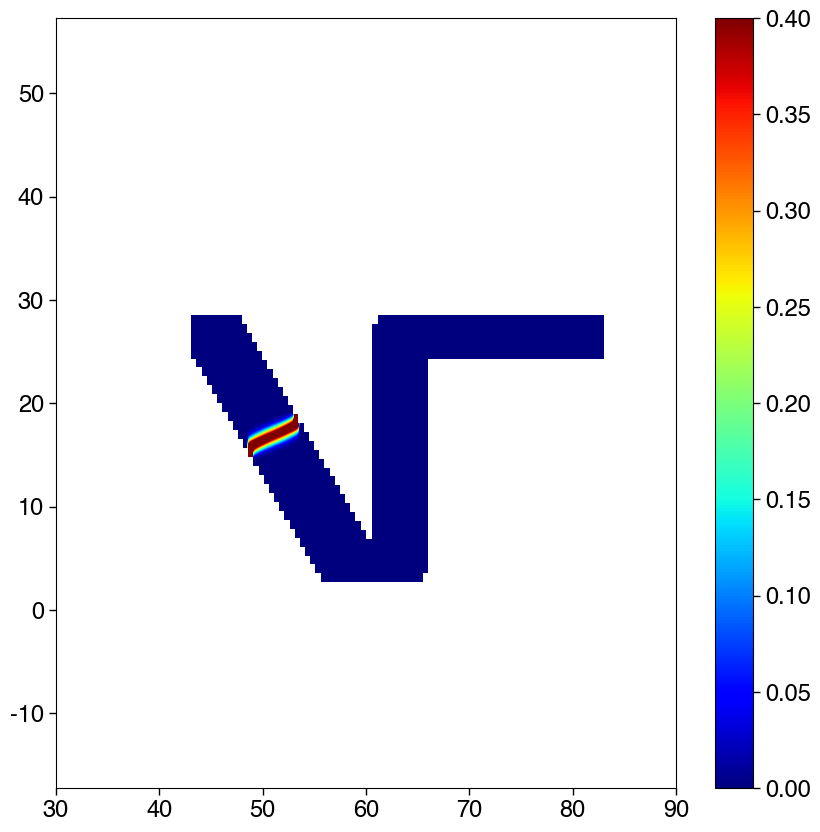

In [204]:
sq32 = np.sqrt(3)/2
fig = plt.figure(figsize=(10,10))
plt.imshow(hexed_afs_up_smooth,cmap='jet',extent=[0,Npos,Npos*sq32,0*sq32],aspect=sq32, vmin=0, vmax=0.4)
plt.colorbar()
plt.axis("equal")
plt.xlim(30,90)
plt.ylim(-10,50)

# Data Analysis

## Mean Firing rate of each cell in the four sectors

In [24]:
#24-2 = 20  # leave two at entrance and two at exit
#20//5 = 4  # each sector has 5 points 

# sectorA: idx 33-37
# sectorB: idx 38-42
# sectorC: idx 43-47
# sectorD: idx 48-52

In [205]:
nrun = 0
place_fields_1 = np.zeros((Np, len(path_locations_1)))
place_fields_2 = np.zeros((Np, len(path_locations_2)))


for i in range(len(path_locations_1)):
    place_fields_1[:,i] = pbook[nrun,:,path_locations_1[i][0], path_locations_1[i][1]]
    
for i in range(len(path_locations_2)):
    place_fields_2[:,i] = pbook[nrun,:,path_locations_2[i][0], path_locations_2[i][1]]

In [206]:
# compute the mean firing rate of each of the place cell in each region 

mfrA_1 = np.mean(place_fields_1[:,33:38], axis=1)
mfrB_1 = np.mean(place_fields_1[:,38:43], axis=1)
mfrC_1 = np.mean(place_fields_1[:,43:48], axis=1)
mfrD_1 = np.mean(place_fields_1[:,48:53], axis=1)

mfrA_2 = np.mean(place_fields_2[:,33:38], axis=1)
mfrB_2 = np.mean(place_fields_2[:,38:43], axis=1)
mfrC_2 = np.mean(place_fields_2[:,43:48], axis=1)
mfrD_2 = np.mean(place_fields_2[:,48:53], axis=1)

stdfrA_1 = scipy.stats.sem(place_fields_1[:,33:38], axis=1)
stdfrB_1 = scipy.stats.sem(place_fields_1[:,38:43], axis=1)
stdfrC_1 = scipy.stats.sem(place_fields_1[:,43:48], axis=1)
stdfrD_1 = scipy.stats.sem(place_fields_1[:,48:53], axis=1)

stdfrA_2 = scipy.stats.sem(place_fields_2[:,33:38], axis=1)
stdfrB_2 = scipy.stats.sem(place_fields_2[:,38:43], axis=1)
stdfrC_2 = scipy.stats.sem(place_fields_2[:,43:48], axis=1)
stdfrD_2 = scipy.stats.sem(place_fields_2[:,48:53], axis=1)

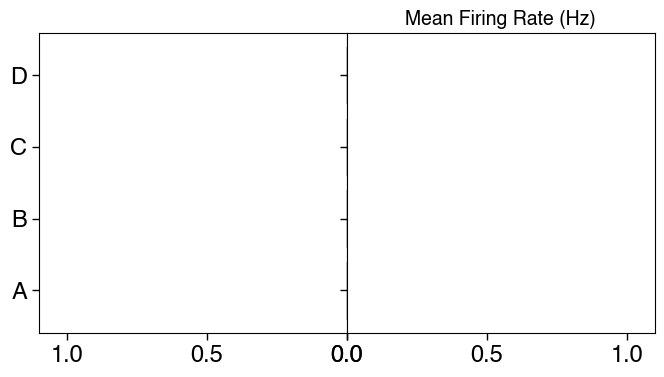

In [220]:
#Making histograms similar to Wood et al 2000
idx = 23
fig, ax = plt.subplots(figsize=(8,4), ncols=2, sharey=True) 
ind = np.arange(4)    # the y locations for the regions
width=0.35

Means   = (mfrA_1[idx], mfrB_1[idx], mfrC_1[idx], mfrD_1[idx])
Std     = (stdfrA_1[idx], stdfrB_1[idx], stdfrC_1[idx], stdfrD_1[idx])
plt_1 = ax[0].barh(ind, Means, color='r', capsize=6, align='center',edgecolor = "k", linewidth=0.3)
#plt_1 = ax[0].barh(ind, Means, color='r', xerr=Std, capsize=6, align='center',edgecolor = "k", linewidth=0.3)

#plt_1 = ax[0].barh(ind, Means, color='b', capsize=6, align='center')


Means   = (mfrA_2[idx], mfrB_2[idx], mfrC_2[idx], mfrD_2[idx])
Std     = (stdfrA_2[idx], stdfrB_2[idx], stdfrC_2[idx], stdfrD_2[idx])
#plt_2 = ax[1].barh(ind, Means, color='b', xerr=Std, capsize=6, align='center',edgecolor = "k", linewidth=0.3)
plt_2 = ax[1].barh(ind, Means, color='b', capsize=6, align='center',edgecolor = "k", linewidth=0.3)
#plt_2 = ax[1].barh(ind, Means, color='r', capsize=6, align='center')



# invert the x-axis of the left plot
ax[0].invert_xaxis() 

plt.yticks(ind+width/50., ('A', 'B', 'C', 'D') )

plt.subplots_adjust(wspace=0, top=0.85, bottom=0.1, left=0.18, right=0.95)

ax[1].set_xlim(0,1.1)
ax[0].set_xlim(1.1,0)

plt.title("Mean Firing Rate (Hz)", fontsize=14)
plt.show()

(0.0, 50.0)

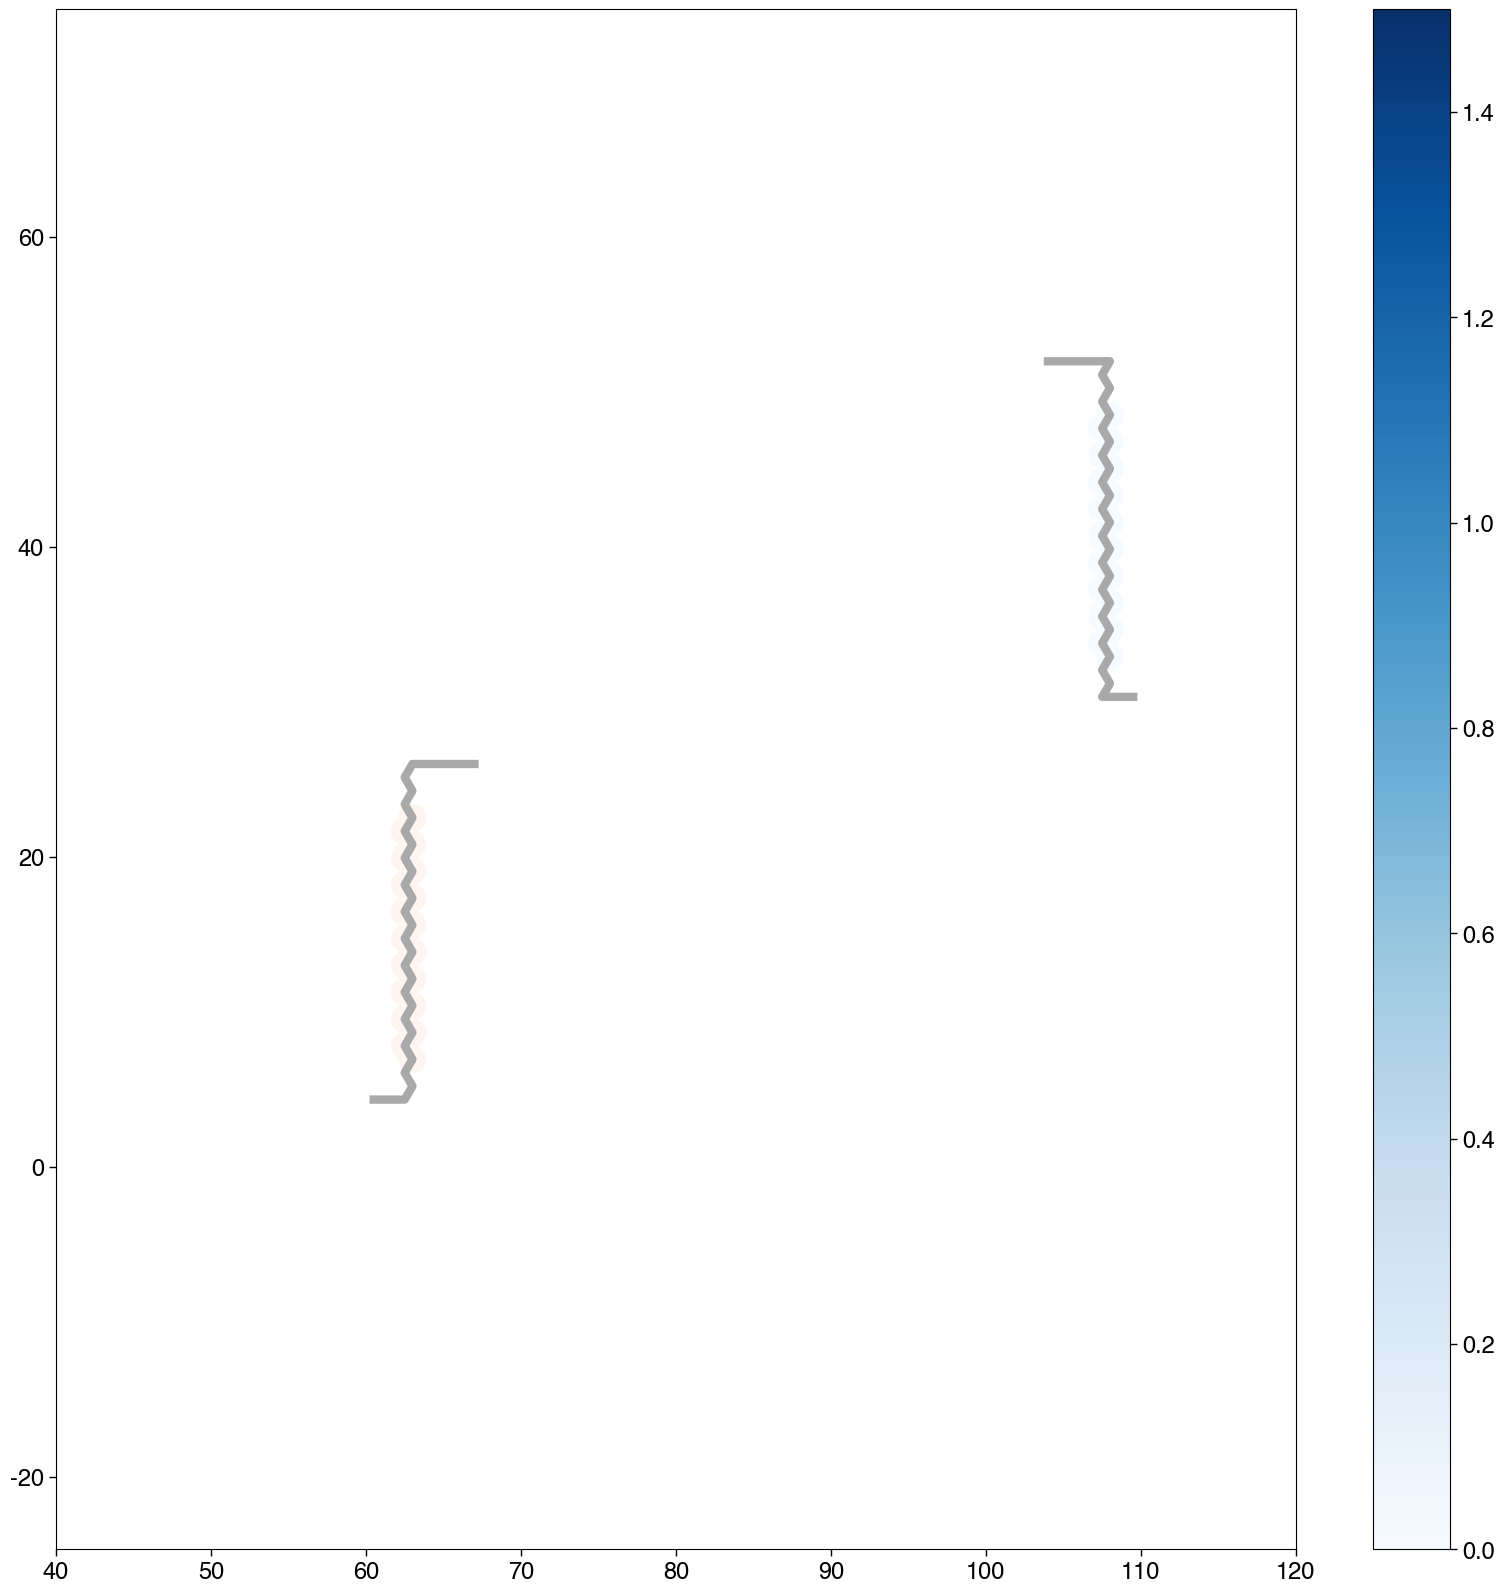

In [221]:
# plotting place fields
plt.figure(figsize = (20,20))

# trajectories
plt.plot(*zip(*hex_path_locations_1[28:60]),'-', color="darkgrey", linewidth=6)
plt.plot(*zip(*hex_path_locations_2[28:60]),'-', color="darkgrey", linewidth=6)

# place fields
plt.scatter(*zip(*hex_path_locations_1[33:52]), c=place_fields_1[idx][33:52], s=400, edgecolors="white", linewidths=0.1, cmap = 'Reds', vmin=0, vmax=1.5)
plt.scatter(*zip(*hex_path_locations_2[33:52]), c=place_fields_2[idx][33:52], s=400, edgecolors="white", linewidths=0.1, cmap = 'Blues', vmin=0, vmax=1.5)


plt.axis('equal')
plt.colorbar()
plt.xlim(40,120)
plt.ylim(0,50) 

# plt.xlim(40,85)
# plt.ylim(5,30) 

## Frequency Distribution of Cells that Fired Preferentially

Here we follow the same analysis as described in Wood et al (2000)

In [223]:
# discard cells with no firing on any of the sectors
maxfr = np.max((mfrA_1,mfrB_1,mfrC_1,mfrD_1, mfrA_2,mfrB_2,mfrC_2,mfrD_2), axis=0)
idx_lst = np.where(maxfr != 0.0)[0]  # cells that fire on at least one of the sectors

total_cells_considered = len(idx_lst)
total_cells_considered

293

In [224]:
diffmfrA = np.abs(mfrA_1 - mfrA_2)
diffmfrB = np.abs(mfrB_1 - mfrB_2)
diffmfrC = np.abs(mfrC_1 - mfrC_2)
diffmfrD = np.abs(mfrD_1 - mfrD_2)

# sector with max'm difference in firing rates
maxsector = np.argmax((diffmfrA,diffmfrB,diffmfrC,diffmfrD), axis=0)
# A,B,C,D => 0,1,2,3

In [228]:
ratio_1 = []   # fields on route 1>2
ratio_2 = []   # fields on route 2>1

for i in idx_lst:
    if maxsector[i] == 0:
        if mfrA_1[i] > mfrA_2[i]:
            ratio_1.append(mfrA_1[i]/mfrA_2[i])
        else:
            ratio_2.append(mfrA_2[i]/mfrA_1[i])
    elif maxsector[i] == 1:
        if mfrB_1[i] > mfrB_2[i]:
            ratio_1.append(mfrB_1[i]/mfrB_2[i])
        else:
            ratio_2.append(mfrB_2[i]/mfrB_1[i])
    elif maxsector[i] == 2:
        if mfrC_1[i] > mfrC_2[i]:
            ratio_1.append(mfrC_1[i]/mfrC_2[i])
        else:
            ratio_2.append(mfrC_2[i]/mfrC_1[i])
    elif maxsector[i] == 3:
        if mfrD_1[i] > mfrD_2[i]:
            ratio_1.append(mfrD_1[i]/mfrD_2[i])
        else:
            ratio_2.append(mfrD_2[i]/mfrD_1[i])
            
ratio_1 = np.array(ratio_1)   
ratio_2 = np.array(ratio_2)  

#print(ratio_1)

import math
ratio_1[ratio_1 == math.inf] = 21
ratio_2[ratio_2 == math.inf] = 21

C:\Users\chand\AppData\Local\Temp\ipykernel_25324\3886102714.py:17: RuntimeWarning: divide by zero encountered in double_scalars
  ratio_1.append(mfrC_1[i]/mfrC_2[i])
C:\Users\chand\AppData\Local\Temp\ipykernel_25324\3886102714.py:9: RuntimeWarning: divide by zero encountered in double_scalars
  ratio_2.append(mfrA_2[i]/mfrA_1[i])
C:\Users\chand\AppData\Local\Temp\ipykernel_25324\3886102714.py:24: RuntimeWarning: divide by zero encountered in double_scalars
  ratio_2.append(mfrD_2[i]/mfrD_1[i])
C:\Users\chand\AppData\Local\Temp\ipykernel_25324\3886102714.py:14: RuntimeWarning: divide by zero encountered in double_scalars
  ratio_2.append(mfrB_2[i]/mfrB_1[i])
C:\Users\chand\AppData\Local\Temp\ipykernel_25324\3886102714.py:22: RuntimeWarning: divide by zero encountered in double_scalars
  ratio_1.append(mfrD_1[i]/mfrD_2[i])
C:\Users\chand\AppData\Local\Temp\ipykernel_25324\3886102714.py:19: RuntimeWarning: divide by zero encountered in double_scalars
  ratio_2.append(mfrC_2[i]/mfrC_1[i])

Text(0, 0.5, 'number of cells')

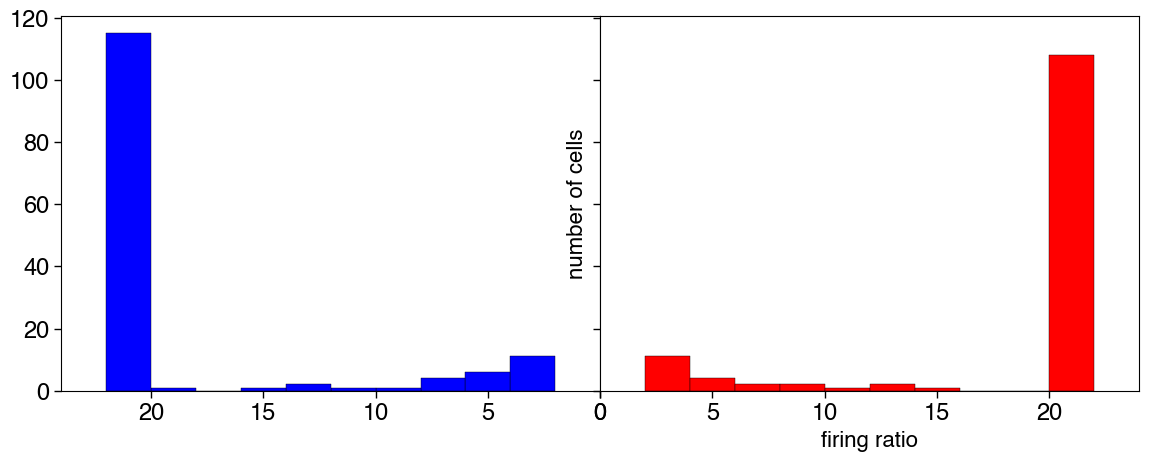

In [230]:
fig, ax = plt.subplots(figsize=(14,5), ncols=2, sharey=True) 
ax[0].hist(ratio_2, color='b', bins=np.arange(2,24,2), edgecolor = "k", linewidth=0.3);
ax[1].hist(ratio_1, color='r', bins=np.arange(2,24,2), edgecolor = "k", linewidth=0.3);

# invert the x-axis of the left plot
ax[0].invert_xaxis();
# ax[1].set_xlim(0,32)
# ax[0].set_xlim(32,0)

ax[1].set_xlim(0,24)
ax[0].set_xlim(24,0)
plt.subplots_adjust(wspace=0, top=0.85, bottom=0.1, left=0.18, right=0.95, hspace=0)
plt.xlabel("firing ratio", fontsize=16)
plt.ylabel("number of cells", fontsize=16)

In [606]:
# cells with non-differential firing
nondiff_1 = np.where(ratio_1<2)
nondiff_2 = np.where(ratio_2<2)
print(nondiff_1, nondiff_2)
total_nondiff = len(nondiff_1[0])+len(nondiff_2[0])

per_nondiff = (total_nondiff/total_cells_considered)*100
print("Percentage of cells with non-differential firing: ", per_nondiff)
print("Percentage of cells with differential firing: ", 100-per_nondiff)

(array([ 35,  37,  45, 106, 145]),) (array([ 34,  57,  71,  93, 104, 124, 154]),)
Percentage of cells with non-differential firing:  3.896103896103896
Percentage of cells with differential firing:  96.1038961038961
